In [1]:
import pandas as pd
import numpy as np
import warnings
from sklearn.feature_selection import VarianceThreshold
warnings.filterwarnings("ignore")
pd.options.display.max_columns = None
import seaborn as sns
import matplotlib.pyplot as plt
# plt.rcParams["figure.figsize"] = (16,7)
from sklearn.model_selection import train_test_split,cross_val_score,KFold
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import roc_curve,roc_auc_score,cohen_kappa_score,confusion_matrix, precision_score,recall_score
from sklearn.ensemble import RandomForestClassifier
from scikitplot.helpers import binary_ks_curve
from matplotlib import pyplot
# pip install scikit-plot

### Read table

In [2]:
df_listings = pd.read_csv('listings.csv')

### Define columns

In [3]:
id_columns = ['id','host_id']

num_vars = df_listings.select_dtypes(include=['int64','float64']).drop(columns=id_columns)
cat_vars = df_listings.select_dtypes(include=['object'])

print('initial numerical vars =',len(num_vars.columns))
print('initial categorical vars =',len(cat_vars.columns))

initial numerical vars = 11
initial categorical vars = 5


### Drop nulls

In [4]:
def drop_nulls(df,threshold):
    missing = pd.DataFrame({'types':df.dtypes, 'percentual_nulo': df.isna().sum()/len(df)})
    missing = missing[missing['percentual_nulo'] > threshold].sort_values(by='percentual_nulo',ascending=False)
    
    #drop
    deletar = list(missing[missing['percentual_nulo'] > threshold].index)
    df_drop = df.drop(columns= deletar,axis=1)
    return df_drop

df_listings = drop_nulls(df_listings,0.5)

### Exploratory data analysis

In [5]:
def num_classification_target(df,vars_numericas):
    
    plot1 = df[df['room_type']==df.room_type.value_counts().index[0]].filter(vars_numericas)
    plot2 = df[df['room_type']==df.room_type.value_counts().index[1]].filter(vars_numericas)
    plot3 = df[df['room_type']==df.room_type.value_counts().index[2]].filter(vars_numericas)
    plot4 = df[df['room_type']==df.room_type.value_counts().index[3]].filter(vars_numericas)
    
    for i in plot1.columns:
        sns.kdeplot(plot1[i].values, bw=0.5,label=df.room_type.value_counts().index[0])
        sns.kdeplot(plot2[i].values, bw=0.5,label=df.room_type.value_counts().index[1])
        sns.kdeplot(plot3[i].values, bw=0.5,label=df.room_type.value_counts().index[2])
        sns.kdeplot(plot4[i].values, bw=0.5,label=df.room_type.value_counts().index[3])
        plt.xlabel(i, fontsize=10)
        plt.show()

### Distribution of numerical features in classification target 

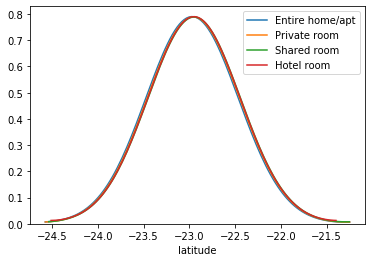

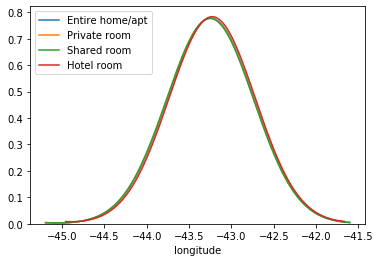

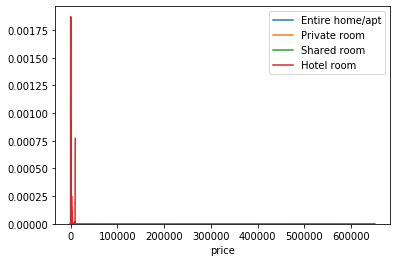

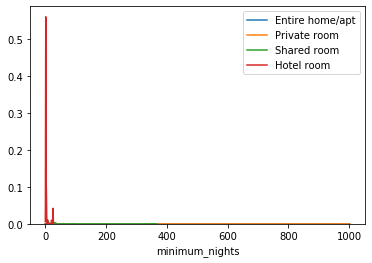

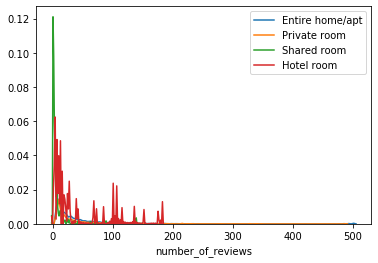

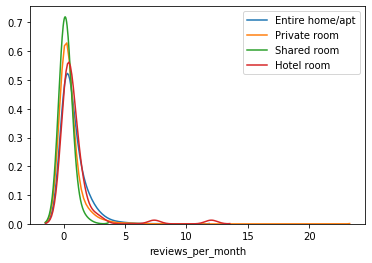

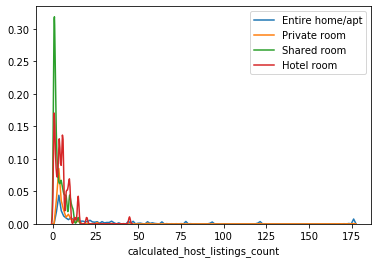

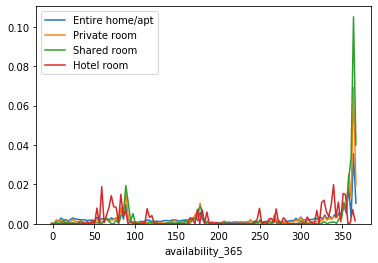

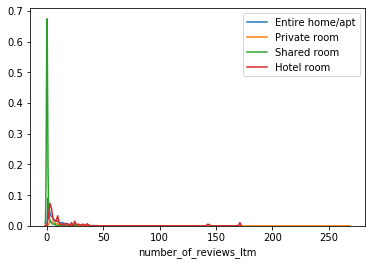

In [6]:
num_classification_target(df_listings,num_vars)

### Box plot without outliers influence

latitude


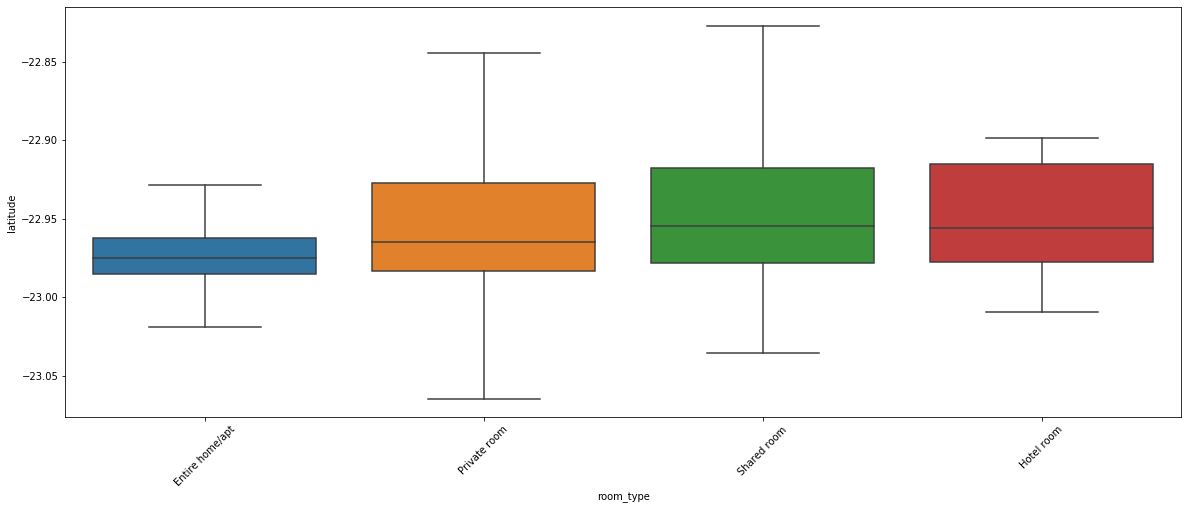

longitude


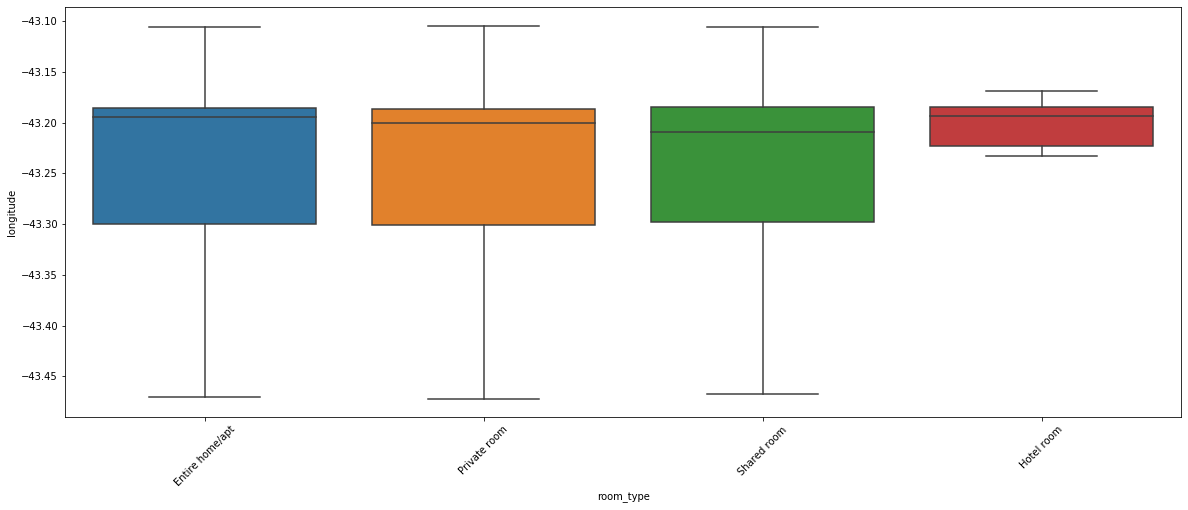

price


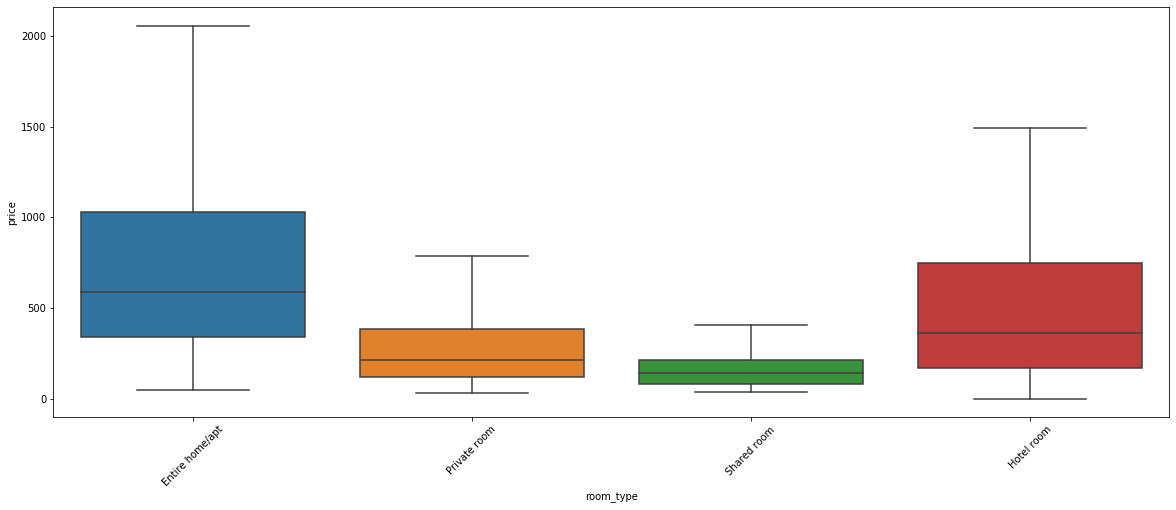

minimum_nights


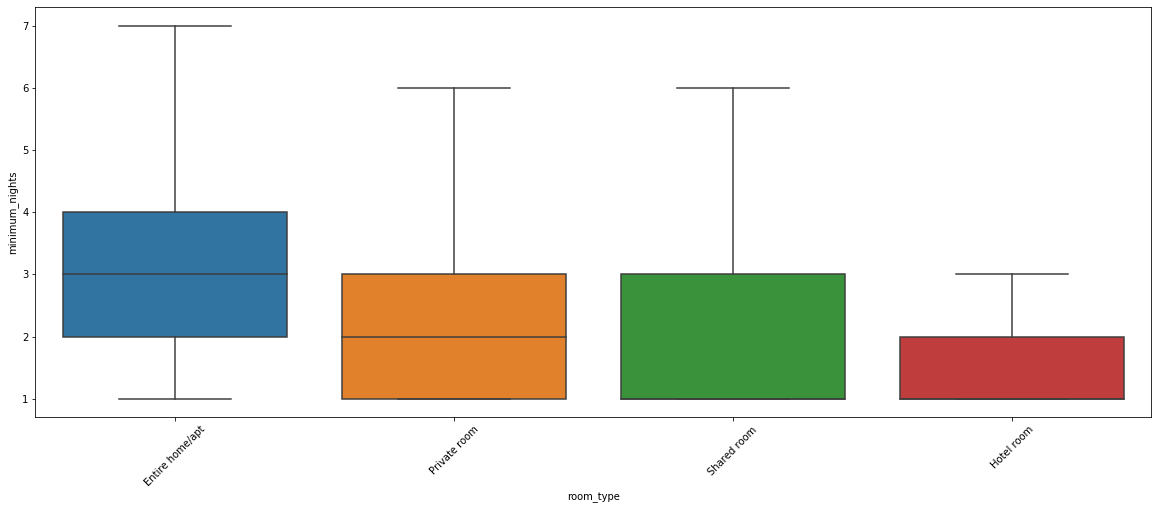

number_of_reviews


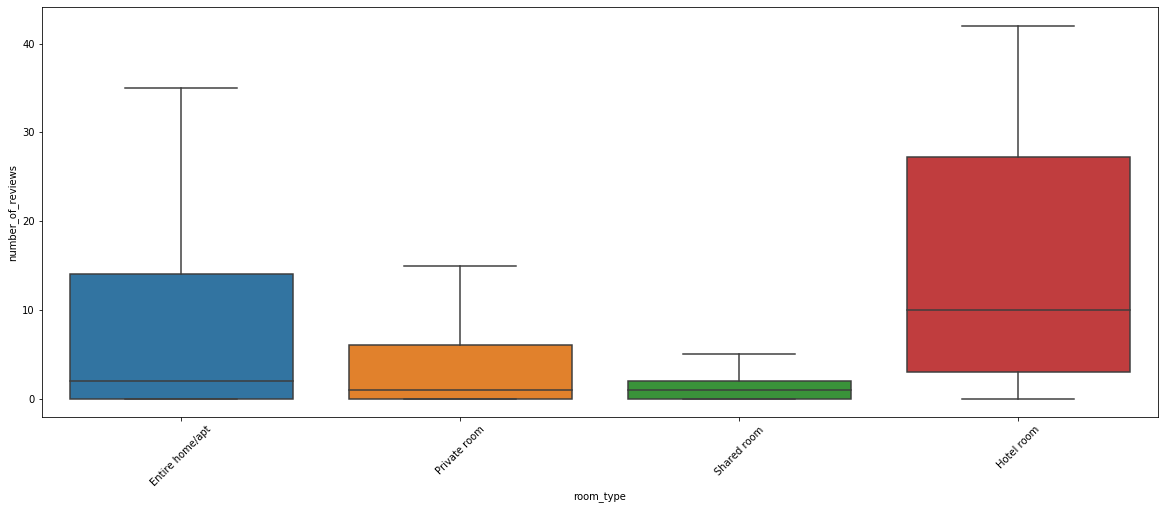

reviews_per_month


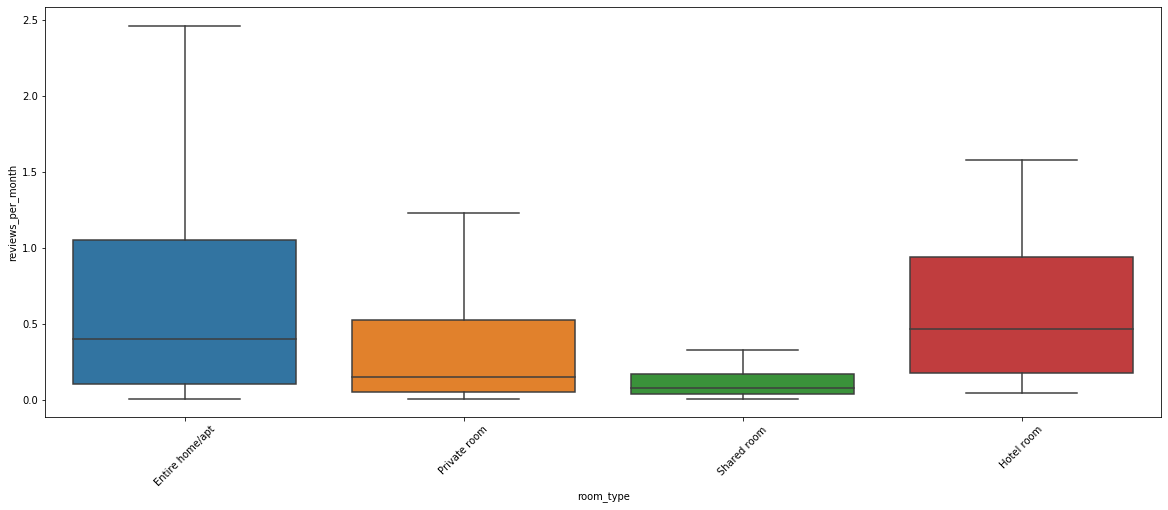

calculated_host_listings_count


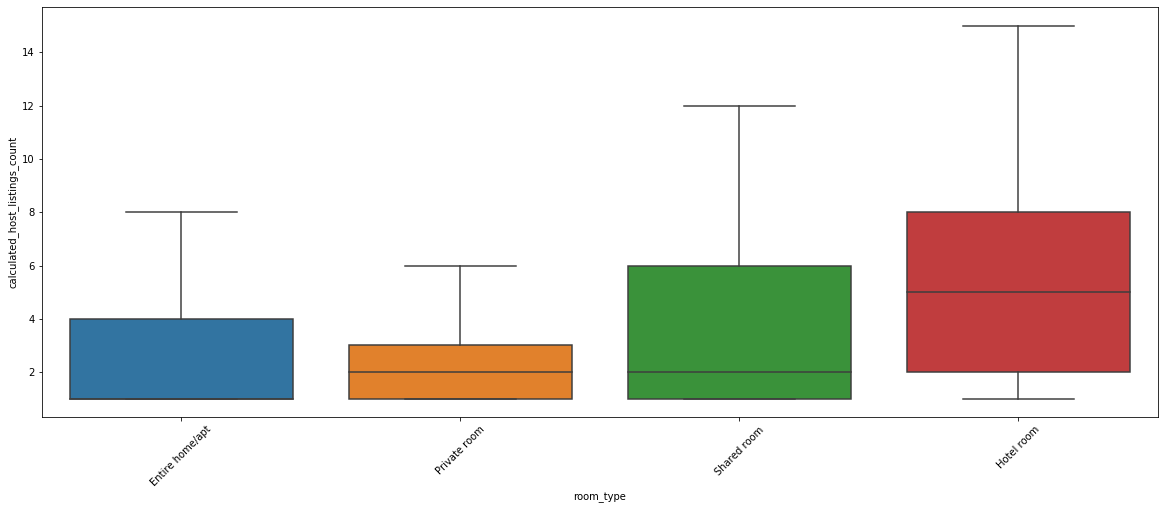

availability_365


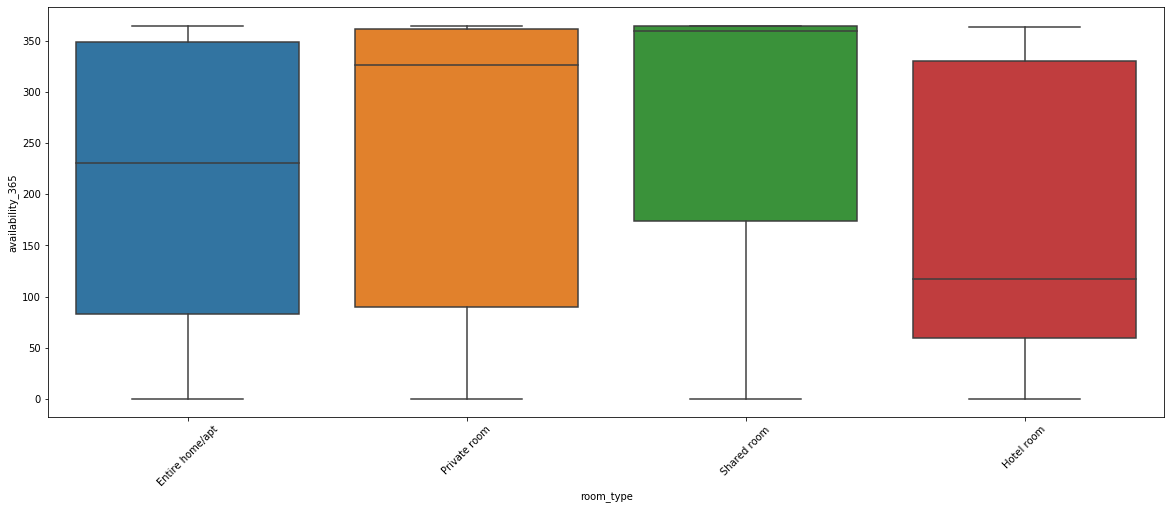

number_of_reviews_ltm


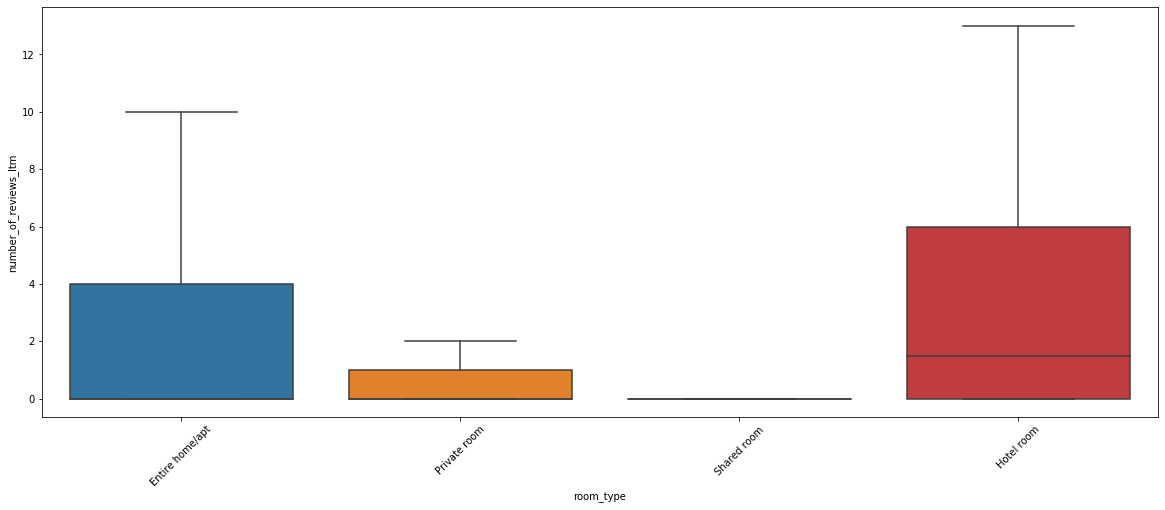

In [7]:
def box_plot_classification_target(df,vars_numericas):
    
    tamanho = len(df_listings.filter(list(num_vars.columns)).columns)
    
    for i, col in enumerate(df_listings.filter(list(num_vars.columns))):
        fig, ax = plt.subplots(figsize=(20, 80))
        plt.subplot(tamanho ,1, i+1)
        plt.xlabel(col, fontsize=10)
        plt.xticks(rotation=45)
        print(col)
        sns.boxplot(
                x='room_type',
                y = col,
                data=df,
                dodge=False,
                showfliers=False,
            #     order = ['1. Marlin', '2. Tilapia', '3. Subsidy Carp', '4. Retention Carp']
                )

        plt.show()

    
box_plot_classification_target(df_listings,num_vars)

### Reduce dimension functions

In [8]:
def variance_threshold(df,threshold):
    vt = VarianceThreshold(threshold=threshold)

    vt.fit(df)

    mask = vt.get_support()

    num_vars_reduced = df.iloc[:, mask]
    return num_vars_reduced

def correlation(df, threshold):
    col_corr = set() # Set of all the names of deleted columns
    corr_matrix = df.corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if (corr_matrix.iloc[i, j] >= threshold) and (corr_matrix.columns[j] not in col_corr):
                colname = corr_matrix.columns[i] # getting the name of column
                col_corr.add(colname)
                if colname in df.columns:
                    del df[colname] # deleting the column from the dataset

    return df

### Target column

In [9]:
df_listings.room_type.value_counts()

Entire home/apt    18564
Private room        5415
Shared room          494
Hotel room            76
Name: room_type, dtype: int64

### Union the low values and verify the new distribution

In [10]:
df_listings['room_type'] = df_listings['room_type']\
                                .replace(['Hotel room',],'Shared_Hotel')\
                                .replace('Entire home/apt','Entire')\
                                .replace('Private room','Private')\
                                .replace('Shared room','Shared_Hotel')
df_listings.room_type.value_counts()

Entire          18564
Private          5415
Shared_Hotel      570
Name: room_type, dtype: int64

### Drop categorical feature with many values

In [11]:
df_listings.select_dtypes('object').nunique()

name             23817
host_name         4884
neighbourhood      154
room_type            3
last_review       1534
dtype: int64

In [12]:
df_listings = df_listings.drop(columns=['host_name','last_review','name'])

### Train and Test Split

In [13]:
x = df_listings.drop(columns=['room_type'])
y = df_listings['room_type']

#Split em treino e teste 
x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.3,random_state=42,stratify=y)

print("number of rows in train data = ",len(x_train))
print('---------------------------')
print(y_train.value_counts().reset_index())
print('---------------------------')
print("number of rows in test data = ",len(x_test))
print('---------------------------')
print(y_test.value_counts().reset_index())

number of rows in train data =  17184
---------------------------
          index  room_type
0        Entire      12995
1       Private       3790
2  Shared_Hotel        399
---------------------------
number of rows in test data =  7365
---------------------------
          index  room_type
0        Entire       5569
1       Private       1625
2  Shared_Hotel        171


### Clip outliers

In [14]:
def clip_outliers(df,drop_columns,q_min,q_max):
    
    num_vars_name = df.select_dtypes(include=['int64','float64']).drop(columns= drop_columns).columns     
    for i in num_vars_name:
        
        #get max and min quantile
        min_value = df.loc[:,i].quantile(q_min)
        max_value = df.loc[:,i].quantile(q_max)

        #replace values with max and min quantile value
        df.loc[:,i] = np.where(df.loc[:,i] < min_value, min_value,df.loc[:,i])
        df.loc[:,i] = np.where(df.loc[:,i] > max_value, min_value,df.loc[:,i])
        
    return df

### Apply feature selection

In [15]:
num_vars_vt = variance_threshold(num_vars,threshold = 0)
num_vars_vt_corr = correlation(num_vars_vt, threshold = 0.7)

#Scaler feature for clustering analyses
scaler = MinMaxScaler()
scaler.fit(x_train.filter(num_vars_vt_corr))

#Apply in train and test
x_train.loc[:,num_vars_vt_corr.columns] = scaler.transform(x_train.loc[:,num_vars_vt_corr.columns])
x_test.loc[:,num_vars_vt_corr.columns] = scaler.transform(x_test.loc[:,num_vars_vt_corr.columns])
         
           
#Select important features
x_train = x_train.filter(list(num_vars_vt_corr.columns)+list(cat_vars)+list(id_columns)).fillna(0)
x_test  =  x_test.filter(list(num_vars_vt_corr.columns)+list(cat_vars)+list(id_columns)).fillna(0)

#Reduce outliers for clustering analyses
x_train = clip_outliers(x_train,drop_columns=id_columns,q_min=0.01,q_max=0.99)
x_test = clip_outliers(x_test,drop_columns=id_columns,q_min=0.01,q_max=0.99)

### Clustering data for input in classification model
- Latitude e longitude
- Preço
- minimo de noites
- numeros de reviews
- availability_365

Silhouette Score for k = 4: 0.439
Silhouette Score for k = 5: 0.473
Silhouette Score for k = 6: 0.410
Silhouette Score for k = 7: 0.414
Silhouette Score for k = 8: 0.378
Silhouette Score for k = 9: 0.390


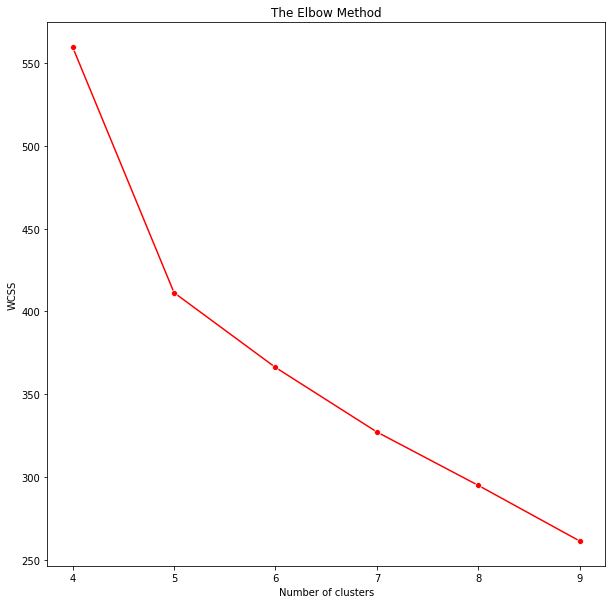

In [16]:
min = 4
max = 10
wcss = []
silhouette= []

train_kmeans = x_train.select_dtypes(include="float64").drop(columns=['number_of_reviews','calculated_host_listings_count'])

for i in range(min, max):
    
    ##Training a kmeans model
    model = KMeans(n_clusters = i, random_state = 42)
    model.fit(train_kmeans)
    
    #Scoring
    pred = model.predict(train_kmeans)
    
    #Get silhouette score
    score = silhouette_score(train_kmeans, pred)
    
    # inertia method returns wcss for that model
    wcss.append(model.inertia_)
    print('Silhouette Score for k = {}: {:<.3f}'.format(i, score))
    
plt.figure(figsize=(10,max))
sns.lineplot(range(min, max), wcss,marker='o',color='red')
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

### Select the best K 

In [17]:
model = KMeans(n_clusters = 5 , random_state = 42)
model.fit(train_kmeans)

#Scoring
x_train['cluster'] = model.predict(x_train.filter(train_kmeans.columns))
x_test['cluster'] = model.predict(x_test.filter(train_kmeans.columns))

### One vs Rest approach

In [18]:
#Get dummy for target
y_dummy_train =pd.get_dummies(y_train,prefix_sep='_')
y_dummy_test = pd.get_dummies(y_test,prefix_sep='_')

#separate target columns for training and test
y_train_entire = y_dummy_train['Entire']
y_train_private = y_dummy_train['Private']
y_train_shared = y_dummy_train['Shared_Hotel']

y_test_entire = y_dummy_test['Entire']
y_test_private = y_dummy_test['Private']
y_test_shared = y_dummy_test['Shared_Hotel']

### Training a classification model

In [69]:
def train_model(x_train,x_test,y_train,y_test,cols_to_drop,iteracoes_random_search):
    
    print("Define hiperparameters")
    # Number of trees in random forest
    n_estimators = [int(x) for x in np.linspace(start = 100, stop = 500, num = 50)]

    # Number of features to consider at every split
    max_features = ['auto', 'sqrt']

    # Maximum number of levels in tree
    max_depth = [int(x) for x in np.linspace(6, 13, num = 1)]

    # Minimum number of samples required to split a node
    min_samples_split = [int(x) for x in np.linspace(10, 50, num = 5)]

    # Minimum number of samples required to split a node
    min_samples_leaf = [int(x) for x in np.linspace(10, 20, num = 1)]

    # Create the random grid
    random_grid = {'n_estimators': n_estimators,
                   'max_features': max_features,
                   'max_depth': max_depth,
                   'min_samples_split': min_samples_split,
                   'min_samples_leaf': min_samples_leaf}
    
    #Define model
    model = RandomForestClassifier(class_weight= 'balanced' ,criterion='gini')
    
    print("Start training with hiperparameter tuning")
    #Apply Random search 
    model_random = RandomizedSearchCV(estimator = model
                                      , param_distributions = random_grid
                                      , n_iter = iteracoes_random_search
                                      , cv = 5
                                      , random_state=42)
    # Fit the random search model
    model_random.fit(x_train.drop(columns= cols_to_drop),y_train)
    
    #Select the best model
    best_random = model_random.best_estimator_
    
    print("Start training the best model")
    #Train the best model
    model = best_random.fit(x_train.drop(columns= cols_to_drop),y_train)
    
    print("Scoring the train data")
    #Scoring the best model in train dataset
    predict_train_entire = model.predict(x_train.drop(columns= cols_to_drop))
    proba_train_entire = model.predict_proba(x_train.drop(columns= cols_to_drop))[:,1]
    
    print("Scoring the test data")
    #Scoring the best model in test dataset
    predict_test_entire = model.predict(x_test.drop(columns= cols_to_drop))
    proba_test_entire = model.predict_proba(x_test.drop(columns= cols_to_drop))[:,1]
    
    print("Getting metrics")
    # calculate scores
    auc_train = roc_auc_score(y_train, proba_train_entire)
    auc_test = roc_auc_score(y_test, proba_test_entire )

    # calculate roc curves
    fpr_train, tpr_train, _ = roc_curve(y_train, proba_train_entire)
    fpr_test, tpr_test, _ = roc_curve(y_test, proba_test_entire)

    # plot the roc curve for the model
    pyplot.plot(fpr_train, tpr_train, linestyle='--', label='Train')
    pyplot.plot(fpr_test, tpr_test, linestyle='--', label='Test')
    # axis labels
    pyplot.xlabel('False Positive Rate')
    pyplot.ylabel('True Positive Rate')
    # show the legend
    pyplot.legend()
    # show the plot
    pyplot.show()

    # summarize scores
    print('ROC AUC Train =%.3f' % (auc_train))
    print('ROC AUC Test =%.3f' % (auc_test))

    print('-----------------------------------------------------')

    ks_stat_train = binary_ks_curve(y_train, predict_train_entire)[3]
    print('ks train =',ks_stat_train)
    
    ks_stat_test = binary_ks_curve(y_test, predict_test_entire)[3]
    print('ks test =',ks_stat_test)

    print('-----------------------------------------------------')

    cohen_kappa_train = cohen_kappa_score(y_train, predict_train_entire)
    print('Kappa score train=',cohen_kappa_train)
    
    cohen_kappa_test = cohen_kappa_score(y_test, predict_test_entire)
    print('Kappa score test =',cohen_kappa_test)

    print('-----------------------------------------------------')

    recall_train = recall_score(y_train, predict_train_entire)
    print('recall train =',recall_train)
    
    recall_test = recall_score(y_test, predict_test_entire)
    print('recall test =',recall_test)

    print('-----------------------------------------------------')

    precision_train = precision_score(y_train, predict_train_entire)
    print('precision train =',precision_train)
    
    precision_test = precision_score(y_test, predict_test_entire)
    print('precision test =',precision_test)
    
    print("Calculate decil in train")
    print("------------------------")
    avg_tgt = y_train.sum()/len(y_train)
    df_data = x_train.drop(columns= cols_to_drop).copy()
    X_data = df_data.copy()
    df_data['Actual'] = y_train
    df_data['Predict']= model.predict(X_data)
    y_Prob = pd.DataFrame(model.predict_proba(X_data))
    df_data['Prob_1']=list(y_Prob[1])
    df_data.sort_values(by=['Prob_1'],ascending=False,inplace=True)
    df_data.reset_index(drop=True,inplace=True)
    df_data['Decile']=pd.qcut(df_data.index,10,labels=False)
    output_df = pd.DataFrame()
    grouped = df_data.groupby('Decile',as_index=False)
    output_df['Qtd']=grouped.count().Actual
    output_df['Sum_Target']=grouped.sum().Actual
    output_df['Per_Target'] = (output_df['Sum_Target']/output_df['Sum_Target'].sum())*100
    output_df['Per_Acum_Target'] = output_df.Per_Target.cumsum()
    output_df['Max_proba']=grouped.max().Prob_1
    output_df['Min_proba']=grouped.min().Prob_1
    output_df["Per_Pop"] = (output_df["Qtd"]/len(y_train))*100
    output_df["Lift"] = output_df["Per_Acum_Target"]/output_df.Per_Pop.cumsum()
    output_df= output_df.drop(columns='Per_Pop')
    print(round(output_df,3))
    print("------------------------")
    print("Calculate decil in test")
    print("------------------------")
    Avg_tgt = y_test.sum()/len(y_test)
    df_data = x_test.drop(columns= cols_to_drop).copy()
    X_data = df_data.copy()
    df_data['Actual'] = y_test
    df_data['Predict']= model.predict(X_data)
    y_Prob = pd.DataFrame(model.predict_proba(X_data))
    df_data['Prob_1']=list(y_Prob[1])
    df_data.sort_values(by=['Prob_1'],ascending=False,inplace=True)
    df_data.reset_index(drop=True,inplace=True)
    df_data['Decile']=pd.qcut(df_data.index,10,labels=False)
    output_df = pd.DataFrame()
    grouped = df_data.groupby('Decile',as_index=False)
    output_df['Qtd']=grouped.count().Actual
    output_df['Sum_Target']=grouped.sum().Actual
    output_df['Per_Target'] = (output_df['Sum_Target']/output_df['Sum_Target'].sum())*100
    output_df['Per_Acum_Target'] = output_df.Per_Target.cumsum()
    output_df['Max_proba']=grouped.max().Prob_1
    output_df['Min_proba']=grouped.min().Prob_1
    output_df["Per_Pop"] = (output_df["Qtd"]/len(y_test))*100
    output_df["Lift"] = output_df["Per_Acum_Target"]/output_df.Per_Pop.cumsum()
    output_df= output_df.drop(columns='Per_Pop')
    print(round(output_df,3))

### Classificação Entire home/apt 

Define hiperparameters
Start training with hiperparameter tuning
Start training the best model
Scoring the train data
Scoring the test data
Getting metrics


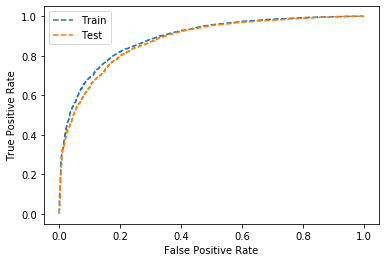

ROC AUC Train =0.892
ROC AUC Test =0.880
-----------------------------------------------------
ks train = 0.623287304710086
ks test = 0.596574619043296
-----------------------------------------------------
Kappa score train= 0.5399197299639273
Kappa score test = 0.5187840414603365
-----------------------------------------------------
recall train = 0.7970757983839939
recall test = 0.7936792961034297
-----------------------------------------------------
precision train = 0.934331589392026
precision test = 0.9258483452031839
Calculate decil in train
------------------------
    Qtd  Sum_Target  Per_Target  Per_Acum_Target  Max_proba  Min_proba   Lift
0  1719      1706.0      13.128           13.128      0.960      0.897  1.312
1  1718      1707.0      13.136           26.264      0.897      0.854  1.313
2  1718      1667.0      12.828           39.092      0.854      0.809  1.303
3  1719      1639.0      12.613           51.705      0.809      0.746  1.293
4  1718      1559.0      11.997

In [71]:
train_model(x_train = x_train,
            x_test = x_test,
            y_train = y_dummy_train['Entire'],
            y_test =  y_dummy_test['Entire'],
            cols_to_drop= ['neighbourhood', 'id', 'host_id'],
            iteracoes_random_search = 10)

### Classificação Entire Private room 

Define hiperparameters
Start training with hiperparameter tuning
Start training the best model
Scoring the train data
Scoring the test data
Getting metrics


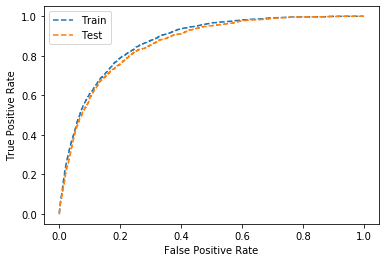

ROC AUC Train =0.874
ROC AUC Test =0.862
-----------------------------------------------------
ks train = 0.5892320548365098
ks test = 0.5694307156258376
-----------------------------------------------------
Kappa score train= 0.482890242592802
Kappa score test = 0.466270263223562
-----------------------------------------------------
recall train = 0.8153034300791556
recall test = 0.8006153846153846
-----------------------------------------------------
precision train = 0.5050670153644982
precision test = 0.4950532724505327
Calculate decil in train
------------------------
    Qtd  Sum_Target  Per_Target  Per_Acum_Target  Max_proba  Min_proba   Lift
0  1719      1261.0      33.272           33.272      0.873      0.774  3.326
1  1718       953.0      25.145           58.417      0.774      0.673  2.921
2  1718       623.0      16.438           74.855      0.672      0.561  2.495
3  1719       416.0      10.976           85.831      0.561      0.456  2.146
4  1718       256.0       6.75

In [72]:
train_model(x_train = x_train,
            x_test = x_test,
            y_train = y_dummy_train['Private'],
            y_test =  y_dummy_test['Private'],
            cols_to_drop= ['neighbourhood', 'id', 'host_id'],
            iteracoes_random_search = 10)

### Classificacao Shared or hotel room

Define hiperparameters
Start training with hiperparameter tuning
Start training the best model
Scoring the train data
Scoring the test data
Getting metrics


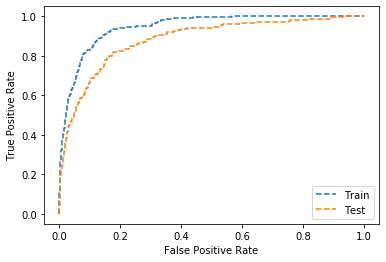

ROC AUC Train =0.945
ROC AUC Test =0.883
-----------------------------------------------------
ks train = 0.7309901205202461
ks test = 0.5770476371635231
-----------------------------------------------------
Kappa score train= 0.23192321346902345
Kappa score test = 0.18206839135205333
-----------------------------------------------------
recall train = 0.8395989974937343
recall test = 0.6900584795321637
-----------------------------------------------------
precision train = 0.15523632993512512
precision test = 0.1267454350161117
Calculate decil in train
------------------------
    Qtd  Sum_Target  Per_Target  Per_Acum_Target  Max_proba  Min_proba   Lift
0  1719       325.0      81.454           81.454      0.940      0.557  8.143
1  1718        49.0      12.281           93.734      0.556      0.400  4.686
2  1718         5.0       1.253           94.987      0.400      0.299  3.166
3  1719        16.0       4.010           98.997      0.299      0.191  2.475
4  1718         3.0      

In [73]:
train_model(x_train = x_train,
            x_test = x_test,
            y_train = y_dummy_train['Shared_Hotel'],
            y_test =  y_dummy_test['Shared_Hotel'],
            cols_to_drop= ['neighbourhood', 'id', 'host_id'],
            iteracoes_random_search = 10)